<a href="https://colab.research.google.com/github/sridevibonthu/SPRAG/blob/main/Inference/modelinference_PyDSVocab_SPRAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install -U sentence-transformers


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.3/163.3 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 36.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

In [3]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer, util
import numpy as np


In [4]:
# Load the trained model
model_path = "/content/drive/MyDrive/PhD/Application/PyDSVocab"
model = SentenceTransformer(model_path)

In [5]:
from sklearn.metrics.pairwise import cosine_similarity
def make_predictions(model, pairs):
    # Initialize an empty list to hold the predicted scores
    scores = []

    # Loop through each pair of sentences
    for pair in pairs:
        # Get the embeddings for the pair of sentences
        sentence_embeddings = model.encode(pair.texts)

        # Calculate the similarity score between the two sentences
        #similarity_score = np.dot(sentence_embeddings[0], sentence_embeddings[1])
        #cosine_sim = cosine_similarity([sentence_embeddings[0]], [sentence_embeddings[1]])[0][0][0]
        cosine_sim = util.cos_sim(sentence_embeddings[0], sentence_embeddings[1])[0][0]
        # Append the similarity score to the list of scores
        scores.append((cosine_sim+1)/2)

    return scores

In [6]:
import pandas as pd
data = pd.read_csv("refstdcombined_ft.csv")
data.columns

Index(['Unnamed: 0', 'QuestionID', 'ReferenceAnswer', 'StudentAnswer',
       'Score1', 'Score2', 'avg_score', 'max_score'],
      dtype='object')

In [7]:
data['bin_score'] = data.apply(lambda row : 1 if row.avg_score>=3 else 0, axis=1)

In [8]:
data = data.dropna()

In [9]:
from sklearn.model_selection import train_test_split

# Storing labels in array
labels = data['bin_score'].values

# Dropping labels column from data
data = data.drop(['bin_score'], axis=1)

# Splitting data into train and test sets in a 70/30 ratio
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, random_state=42, test_size=0.3)

In [10]:
# Prepare sentence pairs (using your provided function)
from sentence_transformers import InputExample
# Select 5 random rows
#random_rows = data.sample(n=1000)

# Extract required columns
ref_answers = test_data['ReferenceAnswer'].tolist()
std_answers = test_data['StudentAnswer'].tolist()
max_scores = test_labels.tolist()
#ref_answers = ['python is easy', 'keywords have predefined meaning', 'List, Set and Dictionary are mutable data structures in python']
#std_answers = ['python is simple', 'i do not know anything', 'Tha object structures which can be changeable are called mutable data structures']
pairs = []
for i in range(len(ref_answers)):
    #print(i)
    pairs.append(InputExample(texts=[ref_answers[i], std_answers[i]]))

In [11]:
# Make predictions using the trained model
predicted_scores = make_predictions(model, pairs)

In [12]:
threshold = 0.6980
#actual = np.where(np.array(random_rows['avg_score'])>=3,1,0)
actual = test_labels
print(actual[:10])
preds_encoded = np.where(np.array(predicted_scores)>threshold,1,0)
print(preds_encoded[:10])

[1 1 1 1 1 0 1 0 1 1]
[1 1 1 1 1 0 1 0 1 1]


In [13]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=True,
                          title="Confusion Matrix",
                          cmap=plt.cm.Blues):

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Plot
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, cmap=cmap, fmt=".2f", xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(title)
    plt.show()



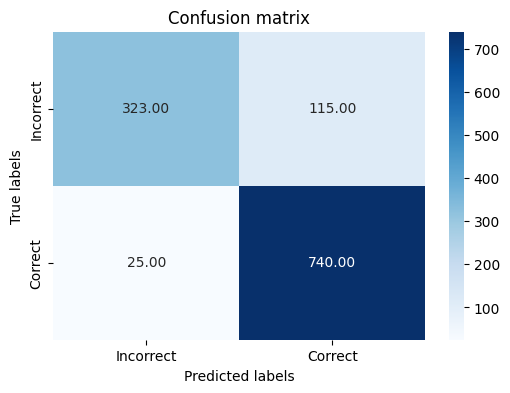

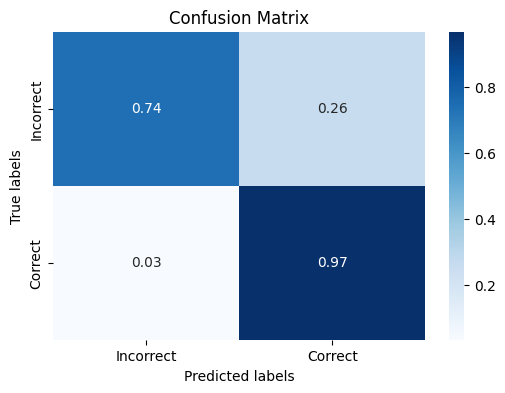

In [14]:
# Example usage:
# Define your actual and predicted binary values
y_true = [0, 1, 0, 1, 1, 0, 1, 0, 0, 1]
y_pred = [0, 1, 1, 1, 1, 0, 0, 0, 1, 1]

# Define class labels
classes = ['Incorrect', 'Correct']

# Plot non-normalized confusion matrix
plot_confusion_matrix(actual, preds_encoded, classes=classes, normalize=False, title='Confusion matrix')

# Plot normalized confusion matrix
plot_confusion_matrix(actual, preds_encoded, classes=classes, normalize=True, title='Confusion Matrix')

In [15]:
from sklearn.metrics import classification_report, accuracy_score
print(classification_report(actual, preds_encoded))

print(accuracy_score(actual, preds_encoded))

              precision    recall  f1-score   support

           0       0.93      0.74      0.82       438
           1       0.87      0.97      0.91       765

    accuracy                           0.88      1203
   macro avg       0.90      0.85      0.87      1203
weighted avg       0.89      0.88      0.88      1203

0.8836242726517041


In [16]:
from sklearn.metrics import f1_score
f1 = f1_score(actual, preds_encoded)
print("F1 Score:", f1)

F1 Score: 0.9135802469135803


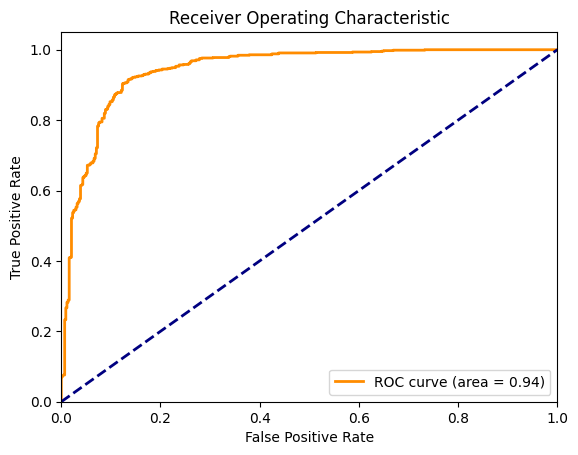

In [17]:
from sklearn.metrics import roc_curve, auc
# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(actual,predicted_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

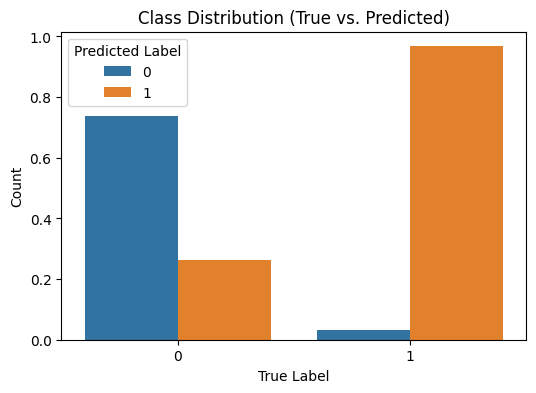

In [18]:
#Class Distribution plot
# Create a DataFrame with true and predicted labels
data = {
    'True Label': actual,
    'Predicted Label': preds_encoded
}
df = pd.DataFrame(data)
# Count occurrences of true and predicted labels
counts = df.groupby(['True Label', 'Predicted Label']).size().reset_index(name='Count')

# Normalize the counts
counts['Normalized Count'] = counts.groupby('True Label')['Count'].transform(lambda x: x / x.sum())

# Plot class distribution
plt.figure(figsize=(6, 4))
sns.barplot(x='True Label', y='Normalized Count', hue='Predicted Label', data=counts)
plt.title('Class Distribution (True vs. Predicted)')
plt.xlabel('True Label')
plt.ylabel('Count')
plt.legend(title='Predicted Label')
plt.show()